# Chirality computations

In [125]:
import os
import sys

import numpy as np
import pandas as pd
import random
from math import isclose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas

from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice
from auxiliary import *
from montecarlo_tools import *
from IPython.display import clear_output

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [126]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [130]:
# Definition of colloids

sp = ice.spins()

trapSep = 10*ureg.um
particleRadius = 5*ureg.um
L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)


#col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

In [131]:
def load_saved_state(main_path,folder):
    file = "/trj9999.csv"
    return pd.read_csv(main_path+folder+file,index_col=0)

def load_saved_energy(main_path,folder):
    file = "/data.csv"
    return pd.read_csv(main_path+folder+file,index_col=0)["0"].to_list()

In [132]:
main_path = "../data/test9/mc/"
angles = os.listdir(main_path)

final_states = { directory:get_colloids_from_ctrj(load_saved_state(main_path,directory),particle,trap,particleRadius,L,N) for directory in tqdm(angles) }

100%|██████████| 25/25 [00:05<00:00,  4.50it/s]


In [276]:
import itertools

def create_chiral_space_lattice(a=30,L=10,spos=(15,15)):
    xstart,ystart = spos
    xcoords = np.linspace(xstart,L*a-xstart,L)
    ycoords = np.linspace(ystart,L*a-ystart,L)
    zcoords = [0]

    global_pos = [ np.array(element) for element in itertools.product(xcoords,ycoords,zcoords) ]

    return np.reshape(global_pos,(L,L,3))

def create_chiral_lattice(col,global_pos,a=30,L=10):
    global_idx = np.zeros((L,L,4))
    for i in range(L):
        for j in range(L):
            curpos = global_pos[i,j,:]
            right =  fix_position(curpos + np.array([a/2,0,0]),a,L).round()
            top = fix_position(curpos + np.array([0,a/2,0]),a,L).round()
            left =  fix_position(curpos + np.array([-a/2,0,0]),a,L).round()
            bottom = fix_position(curpos + np.array([0,-a/2,0]),a,L).round()
             
            right_id = get_index_from_position(col,right)
            top_id = get_index_from_position(col,top)
            left_id = get_index_from_position(col,left)
            bottom_id = get_index_from_position(col,bottom)
             
            global_idx[i,j,:] = np.array([right_id,top_id,left_id,bottom_id])
    
    return global_idx

def calculate_single_chirality(col,idxs):
    up = np.array([0,1,0])
    down = -up
    right = np.array([1,0,0])
    left = -right

    positive = [up,left,down,right]
    negative = [left,up,right,down]

    # try positive chirality
    sum_spins = sum(np.dot(col[int(idx)].direction,spin) for idx,spin in zip(idxs,positive))

    if isclose(sum_spins,4,rel_tol=1e-2):
        return 1
    elif isclose(sum_spins,-4,rel_tol=1e-2):
        return -1
    else:
        return 0
    
def calculate_chirality(col,chiral_lattice,a,L):
    s = 0 # initialize

    for i in range(L):
        for j in range(L):
            s += calculate_single_chirality(col,chiral_lattice[i,j,:]) * (-1)**(i+j)

    return s

$$
\sum_{i,j\in\text{nodes}} (-1)^{i+j} \chi_{ij}
$$

In [277]:
a = 30
L = 10
trapSep = 10*ureg.um
particleRadius = 5*ureg.um

phi = []

for key,cur_state in tqdm(final_states.items()):
    pos_lattice = create_chiral_space_lattice()
    idx_lattice = create_chiral_lattice(cur_state,pos_lattice,a,L)
    cur_chirality = calculate_chirality(cur_state,idx_lattice,a,L)

    phi.append([int(key),cur_chirality])


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:06<00:00,  3.75it/s]


In [278]:
data = np.array(phi)
data = data[data[:, 0].argsort()]

Text(0, 0.5, '$\\Phi$ \\, [degrees]')

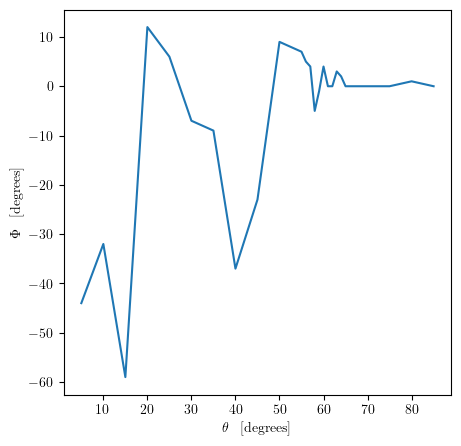

In [279]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(data[:,0],data[:,1])
ax.set_xlabel('$\\theta$ \, [degrees]')
ax.set_ylabel('$\\Phi$ \, [degrees]')

In [280]:
data

array([[  5, -44],
       [ 10, -32],
       [ 15, -59],
       [ 20,  12],
       [ 25,   6],
       [ 30,  -7],
       [ 35,  -9],
       [ 40, -37],
       [ 45, -23],
       [ 50,   9],
       [ 55,   7],
       [ 56,   5],
       [ 57,   4],
       [ 58,  -5],
       [ 59,  -1],
       [ 60,   4],
       [ 61,   0],
       [ 62,   0],
       [ 63,   3],
       [ 64,   2],
       [ 65,   0],
       [ 70,   0],
       [ 75,   0],
       [ 80,   1],
       [ 85,   0]])